In [3]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import time
import psutil

In [4]:
data = pd.read_csv('Datasets/output_with_5g.csv')
for i in range(len(data)):
    if data['delay_qos'][i] == -1000 \
    or data['delay_qos'][i] == 0 or data['avg_bitrate'][i] == 0:
        data = data.drop([i])
        continue
    if data['jitter'][i] == 0:
        data['jitter'][i] = 1
    if data['jitter'][i] == -1000:
        data['jitter'][i] = 1

data['mos'] = data['mos'] / 100

print (str(len(data)) + ' Data Loaded Successfully')

21870 Data Loaded Successfully


In [5]:
# Add more features: Derive new features like interactions (e.g. throughput * delay), polynomials, log transforms etc. More predictive features can reduce MSE.
data['delay_log'] = np.log(data['delay_qos']+1) 

data['bitrate_log'] = np.log(data['avg_bitrate']+1)

data['packet_loss_squared'] = data['packet_loss'] ** 2

data['throughput_jitter'] = data['throughput'] * data['jitter']

data['delay_jitter'] = data['delay_qos'] * data['jitter']

data['loss_rate'] =  data['avg_bitrate'] / (data['packet_loss'] + 1)

In [6]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
X = data.drop('mos', axis=1)
y = data['mos']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection using Random Forest
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_scaled, y)

# Get feature importances and select features
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Select top N features (e.g., top 10)
N = 10
selected_features = indices[:N]
X_selected = X_scaled[:, selected_features]
# If you scaled y
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
X_train_sel, X_test_sel, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42)
# Then split y_scaled instead of y
# Convert data into DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train_sel, label=y_train)
dtest = xgb.DMatrix(X_test_sel, label=y_test)

# Set parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 6,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
    'n_estimators': 1000,
    'seed': 42
}

# Train the model
train_start_time = time.time() # In sec
train_start_memory = psutil.Process().memory_info().rss / 1e6  # in MB
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtest, 'validation')]
)
train_end_memory = psutil.Process().memory_info().rss / 1e6
train_end_time = time.time()

# Make predictions
predict_start_time = time.time()
predict_start_memory = psutil.Process().memory_info().rss / 1e6  # Memory in MB
y_pred_xgb = xgb_model.predict(dtest)
predict_end_memory = psutil.Process().memory_info().rss / 1e6
predict_end_time = time.time()

# Compute metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("XGBoost Model:")
print(f"R²: {r2_xgb:.4f}")
print(f"MSE: {mse_xgb:.8f}")
print(f"RMSE: {rmse_xgb:.8f}")
print(f"MAE: {mae_xgb:.8f}")


[0]	validation-rmse:0.00963
[1]	validation-rmse:0.00956
[2]	validation-rmse:0.00949
[3]	validation-rmse:0.00942
[4]	validation-rmse:0.00935
[5]	validation-rmse:0.00929
[6]	validation-rmse:0.00922
[7]	validation-rmse:0.00915
[8]	validation-rmse:0.00908
[9]	validation-rmse:0.00902
[10]	validation-rmse:0.00895
[11]	validation-rmse:0.00889
[12]	validation-rmse:0.00882
[13]	validation-rmse:0.00878
[14]	validation-rmse:0.00872
[15]	validation-rmse:0.00866
[16]	validation-rmse:0.00860
[17]	validation-rmse:0.00854
[18]	validation-rmse:0.00848
[19]	validation-rmse:0.00842
[20]	validation-rmse:0.00836
[21]	validation-rmse:0.00830
[22]	validation-rmse:0.00825
[23]	validation-rmse:0.00819
[24]	validation-rmse:0.00814
[25]	validation-rmse:0.00808
[26]	validation-rmse:0.00803
[27]	validation-rmse:0.00798
[28]	validation-rmse:0.00792
[29]	validation-rmse:0.00787
[30]	validation-rmse:0.00782
[31]	validation-rmse:0.00778
[32]	validation-rmse:0.00773
[33]	validation-rmse:0.00768
[34]	validation-rmse:0.0

/Users/zahimchared/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [12:06:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[78]	validation-rmse:0.00608
[79]	validation-rmse:0.00605
[80]	validation-rmse:0.00603
[81]	validation-rmse:0.00600
[82]	validation-rmse:0.00598
[83]	validation-rmse:0.00596
[84]	validation-rmse:0.00593
[85]	validation-rmse:0.00591
[86]	validation-rmse:0.00589
[87]	validation-rmse:0.00586
[88]	validation-rmse:0.00584
[89]	validation-rmse:0.00582
[90]	validation-rmse:0.00580
[91]	validation-rmse:0.00578
[92]	validation-rmse:0.00576
[93]	validation-rmse:0.00574
[94]	validation-rmse:0.00572
[95]	validation-rmse:0.00570
[96]	validation-rmse:0.00568
[97]	validation-rmse:0.00566
[98]	validation-rmse:0.00564
[99]	validation-rmse:0.00563
[100]	validation-rmse:0.00561
[101]	validation-rmse:0.00559
[102]	validation-rmse:0.00557
[103]	validation-rmse:0.00555
[104]	validation-rmse:0.00554
[105]	validation-rmse:0.00552
[106]	validation-rmse:0.00551
[107]	validation-rmse:0.00549
[108]	validation-rmse:0.00547
[109]	validation-rmse:0.00546
[110]	validation-rmse:0.00545
[111]	validation-rmse:0.00543
[1

## Benchmark

In [7]:
benchmark = {
    "train_time (s)": round(train_end_time - train_start_time,2),
    "train_memory (MB)": round(train_end_memory - train_start_memory,2),
    "prediction_latency (s)": round(predict_end_time - predict_start_time,2),
    "prediction_memory (MB)": round(predict_end_memory - predict_start_memory,2),
    "throughput (samples/second)": round(len(X_train_sel) / (predict_end_time - predict_start_time), 2)
}

benchmark

{'train_time (s)': 1.91,
 'train_memory (MB)': -15.38,
 'prediction_latency (s)': 0.01,
 'prediction_memory (MB)': 0.02,
 'throughput (samples/second)': 1895138.24}

## Scalability

In [8]:
def resource_scalability(model, X_test, sizes, y_test):
    results = []
    for size in sizes:
        # Extract the subset of features and labels
        subset = X_test[:size]
        label_subset = y_test[:size]  # Match the size of labels with the subset
        
        # Create DMatrix with subset
        dtest = xgb.DMatrix(subset, label=label_subset)
        
        # Start monitoring
        start_time = time.time()
        
        # Predict
        model.predict(dtest)
        
        # Stop monitoring
        end_time = time.time()
        
        # Record results
        results.append({
            "Dataset Size": size,
            "Prediction Delay (s)": round(end_time - start_time, 3),
        })
    
    return results

# Example usage
sizes = [500, 1000, 2000, 3000, len(X_test_sel)]
resource_results = resource_scalability(xgb_model, X_test_sel, sizes, y_test)
scalability_df = pd.DataFrame(resource_results)

# Convert to DataFrame
resource_df = pd.DataFrame(resource_results)
print(resource_df)

   Dataset Size  Prediction Delay (s)
0           500                 0.002
1          1000                 0.002
2          2000                 0.005
3          3000                 0.006
4          4374                 0.007


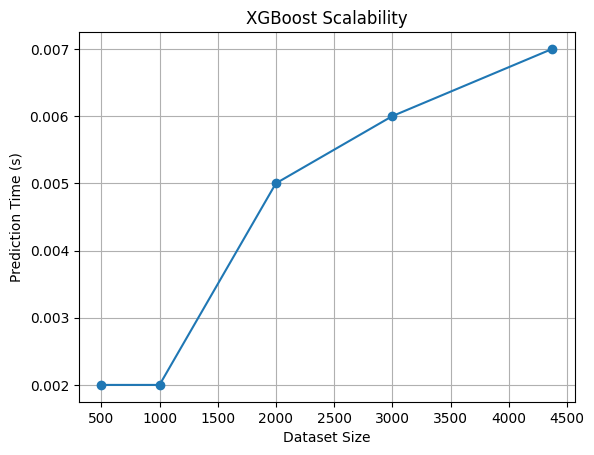

In [9]:
plt.plot(scalability_df["Dataset Size"], scalability_df["Prediction Delay (s)"], marker='o')
plt.title("XGBoost Scalability")
plt.xlabel("Dataset Size")
plt.ylabel("Prediction Time (s)")
plt.grid(True)
plt.show()